# Introduction
Using a transformer-based predtrained model to predict CRISPR (clustered regularly interspaced short palindromic repeats) arrays from metagenomic data. The data come from CRISPRCasdb and our own metagenomic assemblies.

In [1]:
# Imports
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Data pre-processing
The dataset is consist of CRISPR and non-CRISPR sequences and labels ('0' and '1') and no need for normalization or feature engneering.

In [2]:
from datasets import load_dataset

In [3]:
train_dataset = load_dataset('csv', data_files='00.test/crispr.5k.train_valid.csv',split="train")

In [5]:
train_dataset

Dataset({
    features: ['sequences', 'labels'],
    num_rows: 10660
})

In [6]:
train_dataset['labels'][:10]

[0, 0, 0, 0, 0, 1, 0, 1, 1, 1]

In [7]:
test_dataset = load_dataset('csv', data_files="00.test/crispr.1k.test.csv",split="train")

In [8]:
test_dataset

Dataset({
    features: ['sequences', 'labels'],
    num_rows: 1999
})

In [9]:
test_dataset['sequences'][:2]

['ATCGCGCTCCTCGCCTTCCTGCTTGGCGTCGTGCTCGCCTATCAGGGTGCGGACCAGCTCAGGCGGTTTGGCGCCGAGCTTCTGACCGTCAATCTCGTGGCGACCGCAATGTTGCGCGAGGTGGGCTGCCTGATCACAGCCATCGTCGTTGCCGGCCGCTCGGGCTCGGCCTTCACCGCGCAGATCGGTACGATGAAGCTCAATCAGGAAGTCGACGCGATGCAGACCATCGGCCTCAACACGGTCGAAGTTCTCGTGCTGCCGCGCCTCCTCGGGCTCATGGTCGCGCTACCGTTGCTGACGTTCGTTGCCAACATCATGGGCCTGCTCGGCGGCGCGATGATGTGCAACTTCCACTTGGGCATCAACTTCCCCAGCTTTGCGCGCCAGCTCTACACGGTGTTGACGATCAACAGCTGGACCTTCTGGCTCGGCTTCATCAAAGCGCCCGTGTTCGCCGCCATCATCGTTATTGTCGGTTGCTTCGAACGGCTGCGCGTCGAAGGCAATGCTGGCAGTGTCGGCAGCCAGACTACGCGCTCCGTCGTGGA',
 'TATTGGGCTGCCTGTGCGGCAGTGAACGTTATACCCCGCGCAGGGAGTGAAGCGTTGACTTTCTAAGCTGCCTGTGCGGCAGTGAACTTAAGTTCTTTTTGTCAGCATCTTTAATAAATTTTCTAAGCTGCCTGTGCGGCAGTGAACCTGAAATACAAATAAAATAAATCGTCGAACATTTTCTAAGCTGCCTGTGCGGCAGTGAAC']

In [10]:
test_dataset['labels'][:2]

[0, 1]

In [11]:
# Get training data
train_sequences = train_dataset['sequences']
train_labels = train_dataset['labels']

In [12]:
# Split the dataset into a training and a validation dataset
train_sequences, validation_sequences, train_labels, validation_labels = train_test_split(train_sequences,
                                                                              train_labels, test_size=0.3, random_state=42)

# Get test data
test_sequences = test_dataset['sequences']
test_labels= test_dataset['labels']

In [13]:
train_sequences[:2]

['AGCAAATTCTTCACACCAACGCCCAGGAAGCGCTCACGCTTGAAGTCAGCTTCCTGCGTTTGAAGCTCTAACATGGTCGCGACGCGCAATCGCGAGCCGATCTTCGCTGCGCTGTTTGGCGTCATTGTTGCGCTTGTTCTCACCAAAATGGGTAACCCGGTCATCTTCAAGAACATGGAGGTGGCGCCGACGAATCTTGCCGAAGCGGTTTTCGCGACGTGGCCATCTAATTGGTACATCCACGCGTTTGCGATGTCGGCTTTACTTTTGATCGTGGCGTTGATCGGGCAGCGGAACCTTTGGAACCGCACAAAACAAATACCGCGGATCATTACGTTTTCGCTTTGTGGATGGTTCGTTTGGCTTTCGCTGTCGTATTTCAAAACGGTCAATCCGGAATTGACTCGGCTTGCCTATCCTCACCTCTGCGTGTCGGCGGTTTTGCTCTTTGTGGGCTGCGCTCTTCTGTTCGAA',
 'ATCGCGACGATTGTCTGCTTGCTGACGGGCGAGCCGCGCCAGGGCCGTATCGGCATTGGTTGGCGAACGATGGTCAAGGCCCGCGACACGGTGACCCTCGCGGCGCAGCCTTCGTTGACAGTGAGCGATCTCGACCGCGCCGTCGACGAAGTGCAGGCGACGACGGGGCCCGGCTCAGTCGGCGCCCGCCACGCCGTGCTTTCGTCTGTGCTGGCGCGTGCGACGCCGGCGGA']

In [14]:
len(validation_sequences)

3198

In [15]:
len(train_sequences)

7462

In [16]:
# Define the working device
device = torch.device("cuda")

# Model set up

In [17]:
num_labels = 2
# Load the model
model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species", trust_remote_code=True, num_labels=num_labels)
model = model.to(device)

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species and are newly initialized: ['classifier.dense.bias', 

In [18]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species")

In [19]:
from datasets import Dataset

In [20]:
ds_train = Dataset.from_dict({"data": train_sequences,'label':train_labels})
ds_validation = Dataset.from_dict({"data": validation_sequences,'label':validation_labels})
ds_test = Dataset.from_dict({"data": test_sequences,'label':test_labels})

In [21]:
ds_train

Dataset({
    features: ['data', 'label'],
    num_rows: 7462
})

In [22]:
ds_validation

Dataset({
    features: ['data', 'label'],
    num_rows: 3198
})

In [23]:
def tokenize_function(examples):
    outputs = tokenizer(examples["data"],max_length=1000, truncation=True)
    return outputs

In [24]:
# Creating tokenized promoter dataset #map()reshape and remove data
tokenized_datasets_train = ds_train.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_validation = ds_validation.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_test = ds_test.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

Map:   0%|          | 0/7462 [00:00<?, ? examples/s]

Map:   0%|          | 0/3198 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

In [25]:
tokenized_datasets_validation['label'][:10]

[0, 1, 0, 0, 1, 0, 1, 1, 0, 0]

In [31]:
tokenized_datasets_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 7462
})

# Hyperparameter tuning

In [33]:
# Define the metric for the evaluation using the f1 score
def compute_metrics_f1_score(eval_pred):
    """Computes F1 score for binary classification"""
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids
    r={'f1_score': f1_score(references, predictions)}
    return r

In [34]:
batch_size = 8
model_name='nucleotide-transformer'
args_promoter = TrainingArguments(
    f"{model_name}-finetuned-NucleotideTransformer",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-6,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 64,
    num_train_epochs= 2,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="f1_score",
    dataloader_drop_last=True,
    max_steps= 1000
)

In [35]:
trainer = Trainer(
    model.to(device),
    args_promoter,
    train_dataset= tokenized_datasets_train,
    eval_dataset= tokenized_datasets_validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_f1_score,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Results

In [36]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,F1 Score
100,0.568200,0.439688,0.950621
200,0.311100,0.203191,0.974051
300,0.145700,0.091784,0.987914
400,0.063200,0.047770,0.991930
500,0.045000,0.031799,0.994098
600,0.020900,0.023719,0.995949
700,0.019100,0.022078,0.995031
800,0.028000,0.017278,0.997509
900,0.021900,0.016069,0.997197
1000,0.014600,0.015761,0.997197


In [37]:
curve_evaluation_f1_score =[[a['step'],a['eval_f1_score']] for a in trainer.state.log_history if 'eval_f1_score' in a.keys()]
eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
steps = [c[0] for c in curve_evaluation_f1_score]

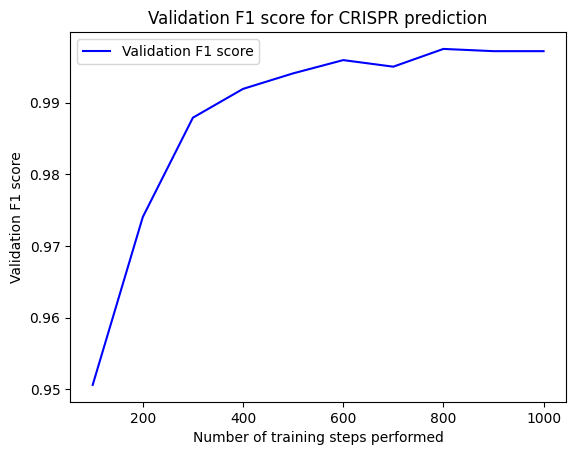

In [38]:
plt.plot(steps, eval_f1_score, 'b', label='Validation F1 score')
plt.title('Validation F1 score for CRISPR prediction')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation F1 score')
plt.legend()
plt.show()

In [39]:
# Compute the F1 score on the test dataset :
print(f"F1 score on the test dataset: {trainer.predict(tokenized_datasets_test).metrics['test_f1_score']}")

F1 score on the test dataset: 0.9964806435394671


In [30]:
#del trainer

In [40]:
import pandas as pd
pd.DataFrame(trainer.state.log_history)

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_f1_score,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.5682,3.946456,9.000000e-07,0.11,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.11,100,0.439688,0.950621,255.1459,12.534,0.196,NaN,NaN,NaN,NaN,NaN
2,0.3111,3.889084,8.000000e-07,0.21,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.21,200,0.203191,0.974051,259.0427,12.345,0.193,NaN,NaN,NaN,NaN,NaN
4,0.1457,6.986619,7.000000e-07,0.32,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.32,300,0.091784,0.987914,254.5479,12.563,0.196,NaN,NaN,NaN,NaN,NaN
6,0.0632,0.435500,6.000000e-07,0.43,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.43,400,0.047770,0.991930,241.6935,13.232,0.207,NaN,NaN,NaN,NaN,NaN
8,0.0450,18.512058,5.000000e-07,0.54,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.54,500,0.031799,0.994098,238.8661,13.388,0.209,NaN,NaN,NaN,NaN,NaN


# spurious arrays

In [41]:
b_dataset = load_dataset('csv', data_files="00.test/spurious.array.166.csv",split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [42]:
b_dataset['sequences'][:2]

['TTATCCCCGCACGCGCGGGGCTGGTCCCACGATGCCGCGCTCGACGAACACCTCGTTCCCGTCGTCCCCGCGTACGCGGGGCTGGTCCCTCGGCCAGCACCCGGCGGAGGTTCCGGATACTGTCGTCCCCACGTACGCGGGGCTGGTCCGATCGATTCGCTGAGGACCTCCGGCAGCACGATGTCGTCCCCGCGCACCTGGGGCTGGTCCGGTGAAGGGCCTCTCCCCGGCCGGGCAGCGGTAGTCGTCCCCGCGTACGCGGGGCTGGTCCCCACACCGGCAAGCCCGAGGCGATCCTCACGCAGTCGTCCCTGCGTTCGCGGGGCTGGTCCCGACACGACGGCGAGCCGGTCGTCGCGTTCCTTGTCGTCCCCGCGTACGCGGGGCTCCTCC',
 'TTCTCAGCCGCACACCTGGCGGCACACCACCGGGGGCTGGCGGCCCCCAAAACTTCTCAGCCGCGCACCTGGCGGCACACCCCTAGCTCATCCCCTTCCGGGCCCTCTGCGTCTTCTCAGCCGCGCGTGTGGCGGCATACTGCGCAGTCAGGGCATCTGCAACTTGCGCGATCTTCTCAGCCGCGCGTGTGGCGGCATACCGCTGATCATCTTGGTAGACCGCGACATATCACTTCTCAGCCGCGCGTGTGGCGGCATACCGC']

In [43]:
b_dataset

Dataset({
    features: ['sequences', 'labels'],
    num_rows: 414
})

In [44]:
b_sequences = b_dataset['sequences']
b_labels= b_dataset['labels']

In [45]:
ds_b = Dataset.from_dict({"data": b_sequences,'label':b_labels})

In [46]:
ds_b

Dataset({
    features: ['data', 'label'],
    num_rows: 414
})

In [47]:
tokenized_datasets_b = ds_b.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

Map:   0%|          | 0/414 [00:00<?, ? examples/s]

In [48]:
trainer.predict(tokenized_datasets_b).metrics

{'test_loss': 4.201750755310059,
 'test_f1_score': 0.0,
 'test_runtime': 30.1907,
 'test_samples_per_second': 13.713,
 'test_steps_per_second': 0.232}

In [1]:
#import torch, gc
#gc.collect()
#torch.cuda.empty_cache()

In [2]:
#del trainer

# Discussion
(1)It is very easy for the model to learn from CRISPR arrays and non-CRISPR arrays.

(2)Batch size, the size of training dataset and validation dataset, and the learning late have a great impact on the model performances.

(3)The model works well on the 1,000 bp and above length sequences.

(4)But the model cannot correctly predict spurious CRISPR arrays (similar to the real CRISPR arrays but non-functional).

(5)The results significantly depend on the input dataset.